# Penerapan Segmentasi Semantik dengan Data Citra Hasil Augmentasi

## Konsep Dasar

Pada dasarnya Deep Learning memerlukan banyak dataset agar mendapatkan model yang terbaik. Namun, untuk mencari data citra yang terdapat hasil digitasi/mask sangatlah susah dalam jumlah banyak, maka dari itu solusi dari kekurangan data tersebut dapat diatasi dengan menggunakan augmentasi. Augmentasi sendiri adalah proses dimana data gambar akan diproses transformasi sedemikian rupa sehingga akan muncul output data gambar baru yang sebenarnya asalnya sama namun akan dikenali unique/berbeda pada PC/Komputer.

Pada notebook ini akan dilakukan proses segmentasi semantik dari data citra hasil augmentasi, dan kita akan melihat hasil prediksinya apakah data augmentasi dapat memberikan hasil yang baik untuk proses ini.

## Penggunaan Library Pytorch Sebagai Inti dari Proses dan Data Augmentasi sebagai Input

In [1]:
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
import fungsiFungsi
import torch
import os, sys

Menentukan peforma eksekusi dengan tenaga CPU karena VRAM Laptop saya kurang gede

In [2]:
#device = torch.device("cuda")  # GPU
device = torch.device("cpu")   # CPU

### Proses Load data untuk Augmentasi

In [3]:
image_dir = 'E:\project_python\ps_final\\train_image\\train\\'
mask_dir = 'E:\project_python\ps_final\\train_mask\\train\\'

In [4]:
file_names = np.sort(os.listdir(image_dir)) 
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])


In [6]:
fungsiFungsi.augmentasi_dataset(count=25, filenames=filenames, image_dir=image_dir, mask_dir=mask_dir)

## Load Data

Proses mengambil data raw dari direktori

In [7]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = fungsiFungsi.dataLoader('E:\project_python\ps_final\\aug_dataset\images\*.jpg', training= True, transform= t)

Pengecekan dataset

In [8]:
print('panjang dataset : ',len(dataset))
print('tipe data dataset : ',type(dataset))

panjang dataset :  200
tipe data dataset :  <class 'fungsiFungsi.dataLoader'>


## Persiapan Train Dataset

Memilah train dan test data

In [9]:
train_dataset = dataset
test_dataset = fungsiFungsi.dataLoader('E:\\project_python\\ps_final\\test_data\\images\\*.jpg', training= True, transform= t)

Jumlah test data

In [11]:
len(test_dataset)

8

Menentukan jumlah batch dan parameter lain data loader pada torch

In [22]:
BATCH_SIZE = 8
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

Jika menggunakan Focal Loss maka uncomment sel dibawah ini

In [ ]:
# criterion = fungsiFungsi.FocalLoss(gamma=3/4).to(device)
# type(criterion)

Jika menggunakan Jaccard Loss maka uncomment sel dibawah ini

In [23]:
criterion = fungsiFungsi.jaccardLoss(n_classes=6).to(device)
type(criterion)

fungsiFungsi.jaccardLoss

## Training Dataset ke Dalam Model

In [24]:
def acc(y, pred_mask):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [25]:
min_loss = torch.tensor(float('inf'))

In [26]:
model = fungsiFungsi.Akatsuki_UNet_Model(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Model Summary

In [27]:
from torchsummary import summary

In [28]:
summary(model)

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,792
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-7               --
|    |    └─DoubleConv: 3-8              221,952
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool2d: 3-9               --
|    |    └─DoubleConv: 3-10             886,272
├─Down: 1-4                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             3,542,016
├─Down: 1-5                              --
|

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,792
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-7               --
|    |    └─DoubleConv: 3-8              221,952
├─Down: 1-3                              --
|    └─Sequential: 2-3                   --
|    |    └─MaxPool2d: 3-9               --
|    |    └─DoubleConv: 3-10             886,272
├─Down: 1-4                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             3,542,016
├─Down: 1-5                              --
|

In [29]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 10
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

Menyiapkan array kosong untuk menyimpan data loss dan akurasi

In [30]:
plot_loss = []
plot_akurasi = []

In [31]:
for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))  
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
 
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))  
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_loss.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  plot_akurasi.append([epoch, np.mean(acc_list), np.mean(val_acc_list)])
  
  # save tiap model ke folder
  torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  

[Epoch 0/10] [Batch 24/25] [Loss: 0.817415 (0.824905)] epoch 0 - loss : 0.82490 - acc : 0.53 - val loss : 0.83065 - val acc : 0.54
[Epoch 1/10] [Batch 24/25] [Loss: 0.779914 (0.772624)] epoch 1 - loss : 0.77262 - acc : 0.58 - val loss : 0.75861 - val acc : 0.61
[Epoch 2/10] [Batch 24/25] [Loss: 0.706520 (0.746261)] epoch 2 - loss : 0.74626 - acc : 0.59 - val loss : 0.77953 - val acc : 0.52
[Epoch 3/10] [Batch 24/25] [Loss: 0.693526 (0.743287)] epoch 3 - loss : 0.74329 - acc : 0.59 - val loss : 0.73845 - val acc : 0.60
[Epoch 4/10] [Batch 24/25] [Loss: 0.703378 (0.728197)] epoch 4 - loss : 0.72820 - acc : 0.60 - val loss : 0.67884 - val acc : 0.62
[Epoch 5/10] [Batch 24/25] [Loss: 0.761620 (0.724558)] epoch 5 - loss : 0.72456 - acc : 0.60 - val loss : 0.79957 - val acc : 0.39
[Epoch 6/10] [Batch 24/25] [Loss: 0.749252 (0.722386)] epoch 6 - loss : 0.72239 - acc : 0.60 - val loss : 0.71149 - val acc : 0.59
[Epoch 7/10] [Batch 24/25] [Loss: 0.702329 (0.716372)] epoch 7 - loss : 0.71637 - a

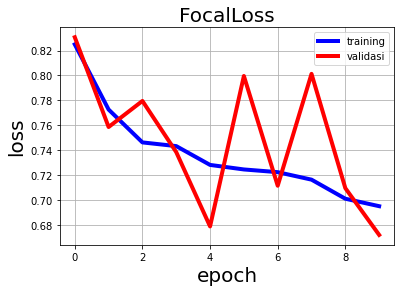

In [32]:
# plot loss
plot_losses = np.array(plot_loss)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validasi']) # using a named size
plt.show()

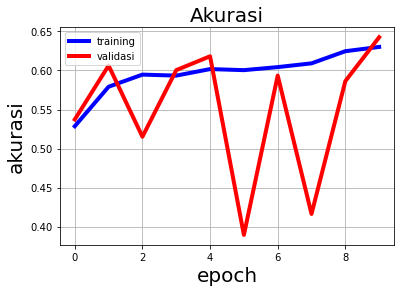

In [33]:
# plot akurasi
plot_akurasi = np.array(plot_akurasi)
plt.plot(plot_akurasi[:,0], plot_akurasi[:,1], color='b', linewidth=4)
plt.plot(plot_akurasi[:,0], plot_akurasi[:,2], color='r', linewidth=4)
plt.title('Akurasi', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('akurasi',fontsize=20)
plt.grid()
plt.legend(['training', 'validasi']) # using a named size
plt.show()

## Testing Data

load model yang telah di train

In [35]:
model.load_state_dict(torch.load('E:\\project_python\\ps_final\\saved_models\\unet_epoch_9_0.67203.pt'))

<All keys matched successfully>

test beberapa data pada variabel test yang sudah didefinisikan diatas

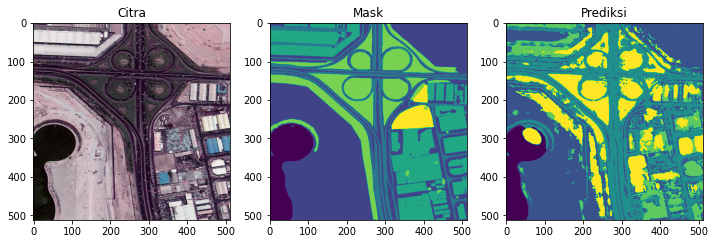

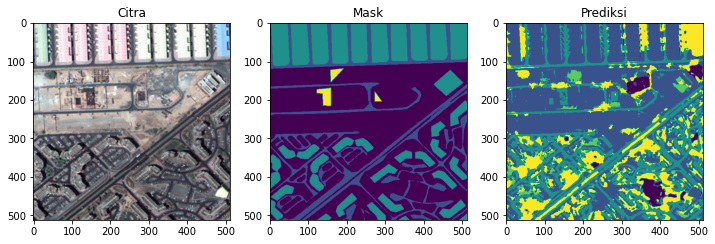

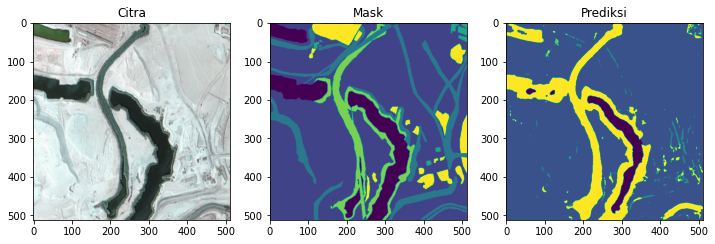

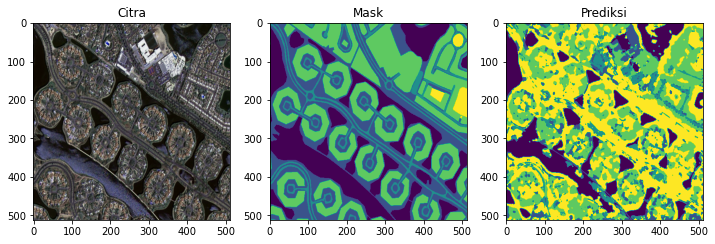

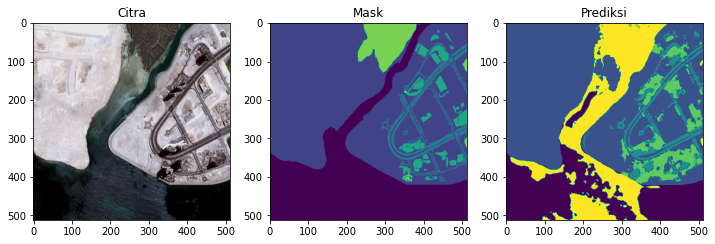

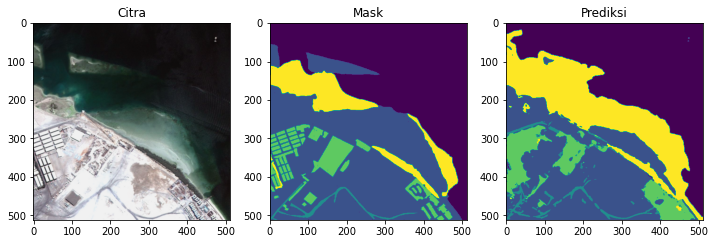

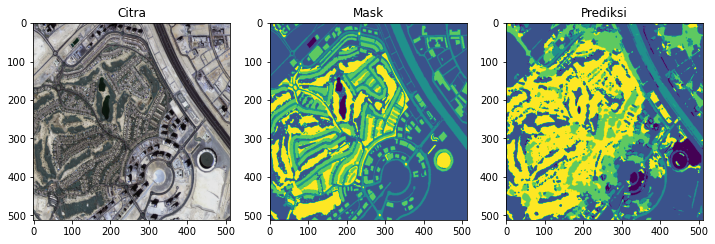

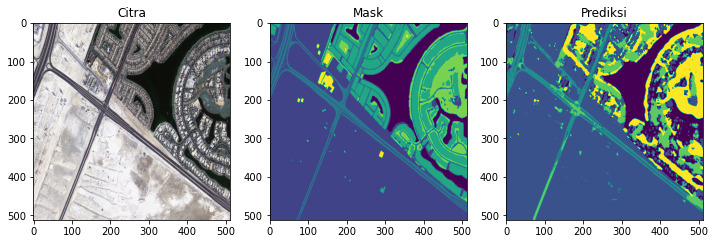

In [38]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1).set_title('Citra')
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2).set_title('Mask')
        plt.imshow(gt_mask)

        plt.subplot(1,3,3).set_title('Prediksi')
        plt.imshow(mask)
        plt.show()

## Kesimpulan

Dalam proses ini didapatkan suatu prediksi dari data asli (bukan augmentasi), dengan akurasi dan loss yang dapat dibilang masih kurang baik. Sepintas hasil prediksi yang dihasilkan dapat mendeteksi objek objek dalam citra sesuai ground truth/mask, namun dikarenakan loss nya masih cukup besar maka masih terdapat kesalahan ketika hendak mengenali objek. Kesalahan ini kemungkinan dapat diminimalisir lagi, mengingat data yang digunakan banyak oleh sebab itu mungkin dapat dipebanyak lagi epoknya.

Kemudian untuk data augmentasi ini rupanya dapat digunakan untuk memperbanyak dataset, sehingga jika kita kekurangan data apalagi membutuhkan mask data sebagai validator tentu tidak mungkin kita mengambil citra lalu dilakukan digitasi satu per satu. Oleh sebab itu, dapat ditarik sebuah kesimpulan bahwa augmentasi dapat dijadikan sebagai solusi dalam memperbanyak dataset untuk training model.